<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> SETUP </H1>

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#For now - 7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
#train_dir = '/content/drive/My Drive/Colab Notebooks/Train'
#validation_dir = '/content/drive/My Drive/Colab Notebooks/Validation'

train_dir = '/content/drive/My Drive/Colab Notebooks/Charts_5/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/Charts_5/Validation'


<H1>BASELINE MODEL</H1>

In [22]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 400
nb_validation_samples = 100
epochs = 100
batch_size = 16

In [23]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [24]:
#Performing augmentation on image scaling, zoom and fliiping the images horizontally so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [25]:
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

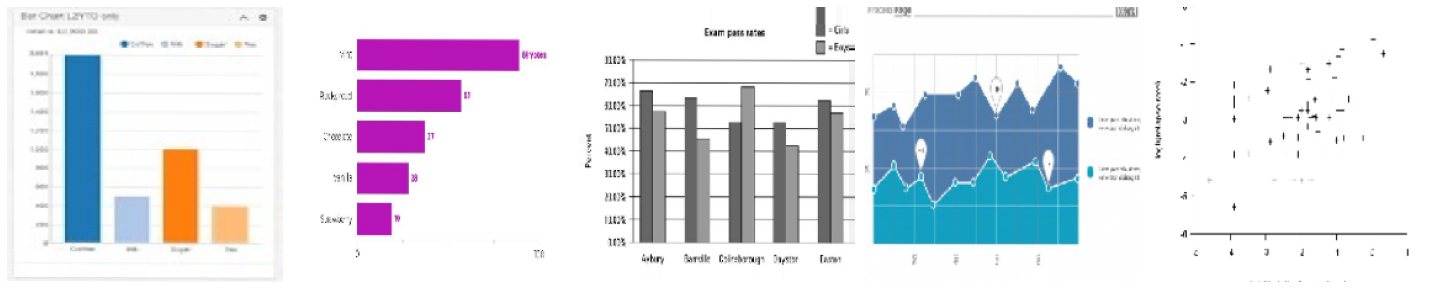

In [26]:
plotImages(sample_training_images[:5])

TRANSFER LEARNING

In [33]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [28]:
base_model.trainable=False

In [31]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(5,activation='softmax')(x) #final layer with softmax activation
tl_model = keras.Model(inputs= base_model.input, outputs=preds)

In [32]:
tl_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history = tl_model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/100
25/25 [==============================] - 8s 323ms/step - loss: 1.6129 - accuracy: 0.1475 - val_loss: 1.6097 - val_accuracy: 0.1979
Epoch 2/100
25/25 [==============================] - 7s 294ms/step - loss: 1.6104 - accuracy: 0.1625 - val_loss: 1.6095 - val_accuracy: 0.1875
Epoch 3/100
25/25 [==============================] - 7s 297ms/step - loss: 1.6098 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2083
Epoch 4/100
25/25 [==============================] - 7s 298ms/step - loss: 1.6098 - accuracy: 0.1375 - val_loss: 1.6094 - val_accuracy: 0.2083
Epoch 5/100
25/25 [==============================] - 7s 296ms/step - loss: 1.6098 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.1979
Epoch 6/100
25/25 [==============================] - 7s 299ms/step - loss: 1.6100 - accuracy: 0.1775 - val_loss: 1.6095 - val_accuracy: 0.1875
Epoch 7/100
25/25 [==============================] - 7s 293ms/step - loss: 1.6100 - accuracy: 0.1550 - val_loss: 1.6094 - val_accuracy: 0.1979

KeyboardInterrupt: ignored

VGG16 KERAS - from scratch

In [ ]:
vgg_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(5, activation='softmax')
])

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [ ]:
from tensorflow.keras.optimizers import Adam

vgg_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
vgg_history = vgg_model.fit( 
  train_generator,
  steps_per_epoch=nb_train_samples // batch_size, 
  epochs=30, 
  validation_data=validation_generator, 
  validation_steps=nb_validation_samples // batch_size) 

Epoch 1/30
25/25 [==============================] - 45s 2s/step - loss: 2.1551 - accuracy: 0.1875 - val_loss: 1.6092 - val_accuracy: 0.2083
Epoch 2/30
25/25 [==============================] - 13s 507ms/step - loss: 1.6115 - accuracy: 0.1650 - val_loss: 1.6095 - val_accuracy: 0.1979
Epoch 3/30
25/25 [==============================] - 13s 507ms/step - loss: 1.6108 - accuracy: 0.1750 - val_loss: 1.6100 - val_accuracy: 0.1979
Epoch 4/30
25/25 [==============================] - 13s 505ms/step - loss: 1.6102 - accuracy: 0.1850 - val_loss: 1.6094 - val_accuracy: 0.2083
Epoch 5/30
25/25 [==============================] - 13s 506ms/step - loss: 1.6099 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.1979
Epoch 6/30
25/25 [==============================] - 13s 510ms/step - loss: 1.6098 - accuracy: 0.1875 - val_loss: 1.6094 - val_accuracy: 0.1979
Epoch 7/30
25/25 [==============================] - 13s 506ms/step - loss: 1.6100 - accuracy: 0.1650 - val_loss: 1.6094 - val_accuracy: 0.2083
Ep